In [12]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from gan import GANWAE

import matplotlib.pyplot as plt

In [13]:
torchvision.datasets.MNIST(
    root='/Users/zhevnerchuk/Desktop/BMML/project/MNIST',
    download=True
)

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: /Users/zhevnerchuk/Desktop/BMML/project/MNIST
    Transforms (if any): None
    Target Transforms (if any): None

In [14]:
batch_size = 30

In [15]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../MNIST',
                               train=True, 
                               download=False,
                               transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))]),
                              ),
    batch_size=batch_size, shuffle=True
)

In [16]:
for X, y in train_loader:
    print(X.shape)
    break

torch.Size([30, 1, 28, 28])


In [17]:
nc = 1
z_dim = 10

class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(tuple([tensor.shape[0]] + self.size))

encoder = nn.Sequential(
            nn.Conv2d(nc, 128, 4, 2, 1, bias=False),              # B,  128, 32, 32
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),             # B,  256, 16, 16
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),             # B,  512,  8,  8
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),            # B, 1024,  4,  4
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            View([-1]),                                 # B, 1024*4*4
            nn.Linear(1024, z_dim)                            # B, z_dim
        )

decoder = nn.Sequential(
            nn.Linear(z_dim, 1024*8*8),                           # B, 1024*8*8
            View([1024, 8, 8]),                               # B, 1024,  8,  8
            nn.ConvTranspose2d(1024, 512, 2, 2, 1, bias=False),   # B,  512, 16, 16
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 1, 1, bias=False),    # B,  256, 32, 32
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 28, 2, 2, 1, bias=False),    # B,  128, 64, 64
            nn.BatchNorm2d(28),
            nn.ReLU(True),
            nn.ConvTranspose2d(28, nc, 1),                       # B,   nc, 64, 64
        )

In [18]:
def sample_latent_prior(batch_size):
    return torch.normal(torch.zeros(batch_size, z_dim), torch.ones(batch_size, z_dim))

In [19]:
def cost(Y_true, Y_pred):
    return torch.nn.functional.mse_loss(Y_pred, Y_true)

In [24]:
class Adversary(nn.Module):
    """Adversary architecture(Discriminator) for WAE-GAN."""
    def __init__(self, z_dim=10):
        super(Adversary, self).__init__()
        self.z_dim = z_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim, 512),                                # B, 512
            nn.ReLU(True),
            nn.Linear(512, 512),                                  # B, 512
            nn.ReLU(True),
            nn.Linear(512, 512),                                  # B, 512
            nn.ReLU(True),
            nn.Linear(512, 512),                                  # B, 512
            nn.ReLU(True),
            nn.Linear(512, 1),                                    # B,   1
        )

    def forward(self, z):
        return self.net(z)

In [46]:
class Divergence(object):
    def __init__(self, adv, optim, lambda_coeff):
        self.adv = adv
        self.optim = optim
        self.lambda_coeff = lambda_coeff
        
    def __call__(self, Z_prior, Z_conditional):
        real = self.adv(Z_prior)
        fake = self.adv(Z_conditional)
        loss = self.lambda_coeff * (torch.sum(torch.log(real)) + torch.sum(torch.log(1 - fake)))
        loss.backward(retain_graph=True)
        self.optim.step()
        self.optim.zero_grad()
        fake = torch.sum(torch.log(self.adv(Z_conditional)))
        return fake

In [47]:
device = torch.device("cuda:"+str(gpu_id) if torch.cuda.is_available() else "cpu")

In [48]:
adv = Adversary(z_dim)

In [49]:
adv_opt = optimizer = torch.optim.Adam(
            adv.parameters(),
            lr=1e-2
        )

In [50]:
divergence = Divergence(adv, adv_opt, 0.1)

In [51]:
optimizer = torch.optim.Adam(
            list(encoder.parameters()) + list(decoder.parameters()),
            lr=1e-2
        )

In [52]:
gan = GANWAE(cost=cost, decoder=decoder, encoder=encoder, device=device, lamda_coeff=0.1, divergence=divergence,
       sample_latent_prior=sample_latent_prior, trainloader=train_loader, optimizer=optimizer)

In [53]:
gan.train(10)

KeyboardInterrupt: 

In [102]:
sample = gan.sample(1)

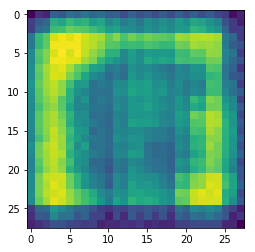

In [103]:
plt.imshow(sample.data.numpy()[0][0])